In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns

In [ ]:
# read portfolio csv file
portfolio = pd.read_csv("portfolio_2020.csv")
portfolio.head()

,Ticker,Name,Category,Original Currency,Sector,Share,Market Price per Share,Weight
0,NVDA,NVIDIA,stock,USD,semicon,37.0,$134.70,0.054822
1,AMD,AMD,stock,USD,semicon,34.0,$119.21,0.044583
2,ASML,ASML,stock,EUR,semicon,6.0,? 681.80,0.046873
3,TSM,TSMC,stock,USD,semicon,20.0,$197.21,0.043385
4,GOOGL,Google,stock,USD,AI/cloud,20.0,$191.41,0.042109


## Create Dataframe of my Portfolio

In [ ]:
# Create Ticker List
tickers = portfolio['Ticker'].tolist()
tickers = ['SPY'] + tickers
# Get Past Price Data (-Kioxia, -Palantir, -Rivian)
data = yf.download(tickers, start='2020-01-01', end='2024-12-23')['Adj Close']
data.shape

[*********************100%***********************]  29 of 29 completed


(1818, 29)

In [ ]:
# Resample all data on a business day basis
cleaned_data = data.resample("B").mean()
# Fill with data from the previous business day (ffill)
cleaned_data.fillna(method="ffill", inplace=True)
cleaned_data.shape

<ipython-input-58-6715e5106a83>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cleaned_data.fillna(method="ffill", inplace=True)


(1298, 29)

In [ ]:
cleaned_data.head()

Ticker,7203.T,AMD,AMZN,ASML,BEP,BTC-USD,BYDDY,CCI,CSCO,DOGE-USD,...,NVDA,PG,QCOM,SPY,TMO,TSLA,TSM,VGK,VWO,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,NaN,NaN,NaN,NaN,NaN,7200.174316,NaN,NaN,NaN,0.002033,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,NaN,49.099998,94.900497,289.478668,19.958683,6985.470215,9.867266,114.592751,41.738205,0.002009,...,5.972710,109.081017,79.384476,301.195007,322.474823,28.684000,54.504318,50.166649,39.011196,56.088295
2020-01-03,NaN,48.599998,93.748497,284.813843,20.207619,7388.952799,9.769472,115.223633,41.057213,0.002268,...,5.877112,108.347374,77.889687,298.914215,318.967224,29.534000,52.706875,49.538399,38.317169,55.637379
2020-01-06,1314.193726,48.389999,95.143997,282.548309,20.513330,7769.219238,9.681458,114.253029,41.203751,0.002463,...,5.901758,108.497627,77.433205,300.054626,321.259552,30.102667,52.098652,49.725174,38.248631,56.064575
2020-01-07,1340.251709,48.250000,95.343002,285.616791,20.574472,8163.692383,9.603225,112.319977,40.936531,0.002433,...,5.973208,107.825874,79.635094,299.210876,323.077545,31.270666,52.942909,49.478966,38.231491,55.605736


In [ ]:
# delete rows include nan
cleaned_data_dropna = cleaned_data.dropna()
port = cleaned_data_dropna
port.shape

(1295, 29)

## Calculate Return

In [ ]:
# Calculate daily returns for each asset
returns = data.pct_change()

# Step 1: 欠損値を削除
returns = returns.dropna()

# Step 2: 行の中に1つでも0が含まれている場合、その行を削除
returns = returns.loc[~(returns == 0).any(axis=1)]

# Display the first few rows of the returns data to confirm
print(returns.head())


<ipython-input-61-2d149f142435>:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change()


Ticker        7203.T       AMD      AMZN      ASML       BEP   BTC-USD  \
Date                                                                     
2020-01-07  0.019828 -0.002893  0.002092  0.010860  0.002981  0.050774   
2020-01-08 -0.012702 -0.008705 -0.007809  0.010375  0.007005 -0.010269   
2020-01-10 -0.001174 -0.016337 -0.009411 -0.017254 -0.005997  0.036487   
2020-01-14  0.010182 -0.011077 -0.011558  0.003649 -0.000434  0.083933   
2020-01-15 -0.008657  0.007052 -0.003969 -0.008164  0.008472 -0.002351   

Ticker         BYDDY       CCI      CSCO  DOGE-USD  ...      NVDA        PG  \
Date                                                ...                       
2020-01-07 -0.008081 -0.016919 -0.006485 -0.012180  ...  0.012107 -0.006191   
2020-01-08  0.005092  0.004177  0.000632 -0.057542  ...  0.001876  0.004263   
2020-01-10  0.001012  0.015330 -0.004015  0.044326  ...  0.005349  0.000969   
2020-01-14  0.007018 -0.009352 -0.003752  0.047498  ... -0.018652 -0.001522   
2020-01

In [ ]:
returns.shape

(1083, 29)

## Beta

In [ ]:
def calculate_beta(returns, market_column="SPY"):
    market_returns = returns[market_column]
    beta_values = {}
    for asset in returns.columns:
        if asset != market_column:
            covariance = np.cov(returns[asset], market_returns)[0, 1]
            market_variance = np.var(market_returns)
            beta_values[asset] = covariance / market_variance
    return beta_values

beta_values = calculate_beta(returns)

In [ ]:
beta_df = pd.DataFrame.from_dict(beta_values, orient='index', columns=['Beta'])
print(beta_df)

              Beta
7203.T    0.229890
AMD       1.602974
AMZN      1.067447
ASML      1.488795
BEP       0.912383
BTC-USD   1.071174
BYDDY     0.970916
CCI       0.836838
CSCO      0.907977
DOGE-USD  1.366540
EEM       0.829596
ENPH      1.653591
FSLR      1.006213
GOOGL     1.148206
IEUR      0.886640
ISRG      1.247577
JNJ       0.481072
MDT       0.839531
MSFT      1.182464
NVDA      1.796221
PG        0.538653
QCOM      1.381702
TMO       0.808748
TSLA      1.652938
TSM       1.137583
VGK       0.895474
VWO       0.781424
XOM       0.843232


## Portfolio Beta

In [ ]:
# type -> dict
def get_portfolio_weights(portfolio):
    weights = dict(zip(portfolio['Ticker'], portfolio['Weight']))
    return weights

portfolio_weights = get_portfolio_weights(portfolio)

In [ ]:
portfolio_weights

{'NVDA': 0.054821544,
 'AMD': 0.044583437,
 'ASML': 0.046872591,
 'TSM': 0.043385127,
 'GOOGL': 0.042109159,
 'MSFT': 0.043222331,
 'AMZN': 0.032162765,
 'MDT': 0.032978394,
 'ISRG': 0.028842937,
 'TMO': 0.028822037,
 'CSCO': 0.032828908,
 'CCI': 0.032908766,
 'QCOM': 0.03195322,
 '7203.T': 0.033056179,
 'TSLA': 0.032420818,
 'BYDDY': 0.021282274,
 'PG': 0.033275057,
 'JNJ': 0.02224783,
 'BEP': 0.032817688,
 'FSLR': 0.044137288,
 'ENPH': 0.033009084,
 'XOM': 0.044252566,
 'IEUR': 0.032572394,
 'VGK': 0.032709781,
 'EEM': 0.033012054,
 'VWO': 0.032721991,
 'BTC-USD': 0.054994325,
 'DOGE-USD': 0.021999456}

In [ ]:
def calculate_portfolio_beta(beta_values, weights):
    portfolio_beta = sum(beta_values[asset] * weight for asset, weight in weights.items())
    return portfolio_beta

portfolio_beta = calculate_portfolio_beta(beta_values, portfolio_weights)
print(f"Portfolio Beta: {portfolio_beta}")

Portfolio Beta: 1.0881734594990478


## Covariance

In [ ]:
returns_matrix = returns.to_numpy()
annualized_cov_matrix = np.cov(returns_matrix, rowvar=False) * 252

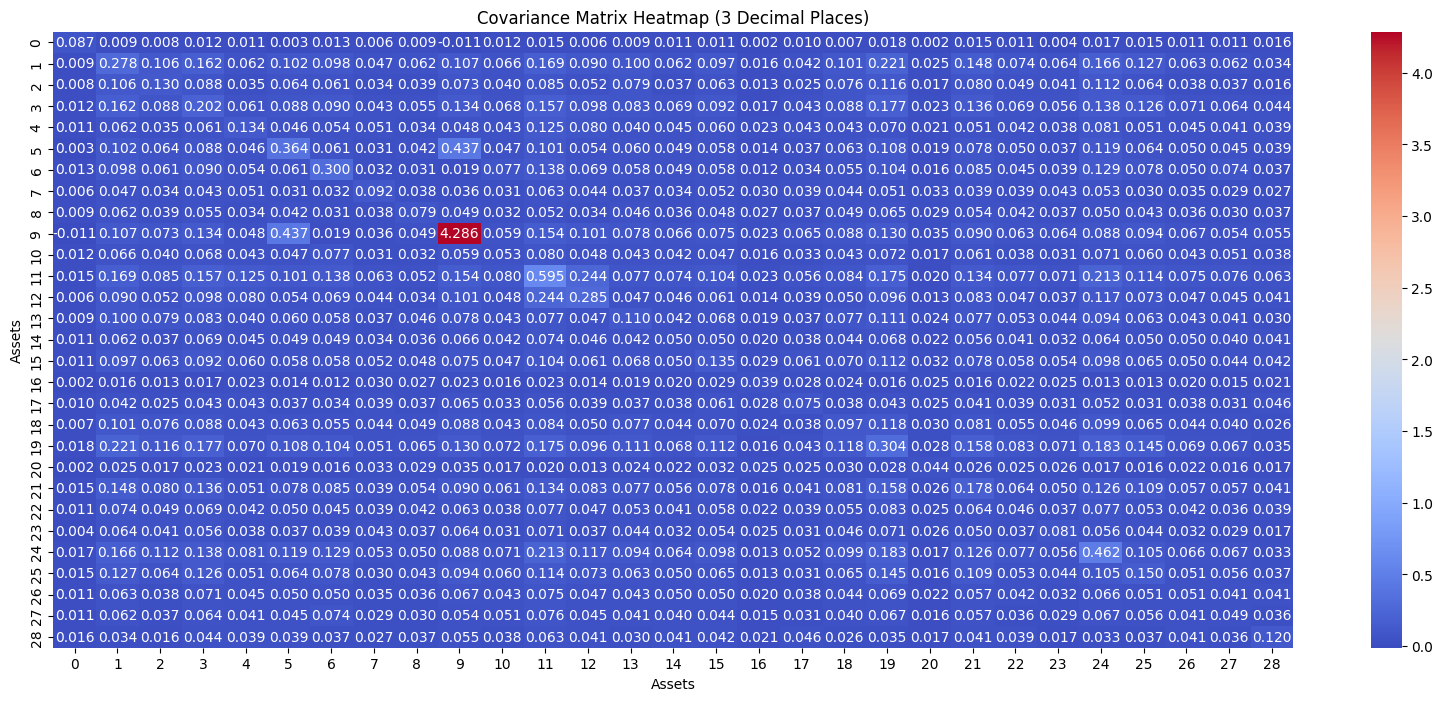

In [ ]:
# Plot the covariance matrix heatmap with 3 decimal places (without rounding)
plt.figure(figsize=(20, 8))
sns.heatmap(annualized_cov_matrix, annot=True, fmt=".3f", cmap="coolwarm", cbar=True)
plt.title("Covariance Matrix Heatmap (3 Decimal Places)")
plt.xlabel("Assets")
plt.ylabel("Assets")
plt.show()


## Correlation Coefficient

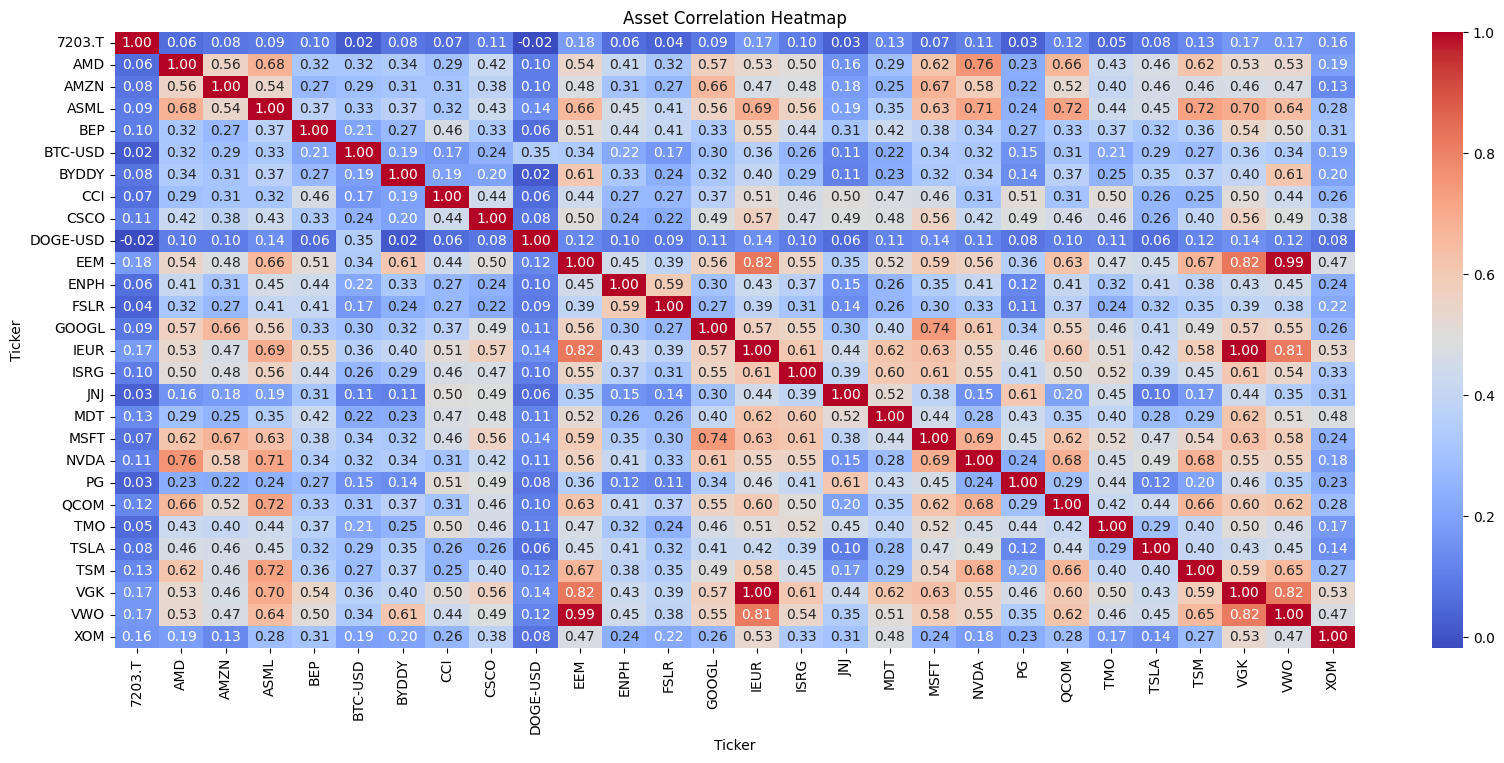

In [ ]:
returns = returns.drop(columns=['SPY'], errors='ignore')
def plot_correlation_heatmap(returns):
    returns = returns.dropna()
    correlation_matrix = returns.corr()
    plt.figure(figsize=(20, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Asset Correlation Heatmap")
    plt.show()

plot_correlation_heatmap(returns)

## Standard Deviation

In [ ]:
def calculate_annualized_portfolio_std(returns, weights):
    weight_array = np.array([weights[asset] for asset in returns.columns if asset in weights])
    annualized_cov_matrix = returns.cov() * 252
    portfolio_variance = np.dot(weight_array.T, np.dot(annualized_cov_matrix, weight_array))
    portfolio_std = np.sqrt(portfolio_variance)
    return portfolio_std

annualized_portfolio_std = calculate_annualized_portfolio_std(returns, portfolio_weights)
print(f"Annualized Portfolio Standard Deviation: {annualized_portfolio_std}")

Annualized Portfolio Standard Deviation: 0.2598827882819741


## Expected Annual Return

In [ ]:
def calculate_expected_return(returns, weights, annualize_factor=252):
    mean_daily_returns = returns.mean()
    expected_daily_return = sum(mean_daily_returns[asset] * weight for asset, weight in weights.items())
    expected_annual_return = expected_daily_return * annualize_factor
    return expected_annual_return

expected_return = calculate_expected_return(returns, portfolio_weights)
print(f"Expected Annual Return: {expected_return}")

Expected Annual Return: 0.298729094950773


## Sharp Ratio

In [ ]:
def calculate_sharpe_ratio(expected_return, portfolio_std, risk_free_rate=0.04):
    sharpe_ratio = (expected_return - risk_free_rate) / portfolio_std
    return sharpe_ratio

sharpe_ratio = calculate_sharpe_ratio(expected_return, annualized_portfolio_std)
print(f"Sharpe Ratio: {sharpe_ratio}")


Sharpe Ratio: 0.9955607166645091


## efficient Frontier

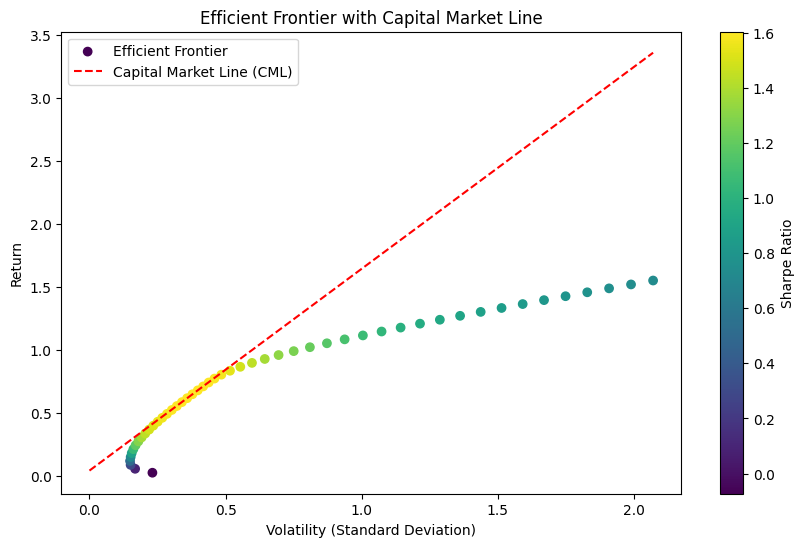

In [ ]:
def calculate_efficient_frontier(returns, risk_free_rate=0.04):
    mean_returns = returns.mean() * 252  # 年率換算
    cov_matrix = returns.cov() * 252  # 年率換算
    num_assets = len(mean_returns)
    results = {
        "returns": [],
        "volatility": [],
        "weights": []
    }

    def portfolio_performance(weights):
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return portfolio_return, portfolio_volatility

    def negative_sharpe_ratio(weights):
        p_return, p_volatility = portfolio_performance(weights)
        return -(p_return - risk_free_rate) / p_volatility

    def minimize_volatility(weights):
        return portfolio_performance(weights)[1]

    # 制約と境界
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))

    # 効率的フロンティアの生成
    for target_return in np.linspace(mean_returns.min(), mean_returns.max(), 50):
        constraints = ({'type': 'eq', 'fun': lambda x: portfolio_performance(x)[0] - target_return},
                       {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        result = minimize(minimize_volatility, num_assets * [1. / num_assets, ], args=(),
                          method='SLSQP', bounds=bounds, constraints=constraints)
        if result.success:
            p_return, p_volatility = portfolio_performance(result.x)
            results["returns"].append(p_return)
            results["volatility"].append(p_volatility)
            results["weights"].append(result.x)

    return results

def plot_efficient_frontier_with_cml(results, risk_free_rate=0.04):
    # 効率的フロンティア
    plt.figure(figsize=(10, 6))
    plt.scatter(results['volatility'], results['returns'], c=(np.array(results['returns']) - risk_free_rate) / np.array(results['volatility']),
                cmap='viridis', marker='o', label='Efficient Frontier')

    # CMLの計算をフロンティア全体に拡張
    max_sharpe_idx = np.argmax((np.array(results['returns']) - risk_free_rate) / np.array(results['volatility']))
    max_sharpe_vol = results['volatility'][max_sharpe_idx]
    max_sharpe_ret = results['returns'][max_sharpe_idx]
    cml_x = np.linspace(0, max(results['volatility']), 100)
    cml_y = risk_free_rate + (max_sharpe_ret - risk_free_rate) / max_sharpe_vol * cml_x
    plt.plot(cml_x, cml_y, color='red', linestyle='--', label='Capital Market Line (CML)')

    plt.colorbar(label='Sharpe Ratio')
    plt.title('Efficient Frontier with Capital Market Line')
    plt.xlabel('Volatility (Standard Deviation)')
    plt.ylabel('Return')
    plt.legend()
    plt.show()

# 効率的フロンティアを計算してプロット
efficient_frontier_results = calculate_efficient_frontier(returns)
plot_efficient_frontier_with_cml(efficient_frontier_results)

In [ ]:
# リターンの確認
print("Mean Returns:\n", returns.mean())
print("Covariance Matrix:\n", returns.cov())
print("Weights:\n", [portfolio_weights[asset] for asset in returns.columns if asset in portfolio_weights])

# 計算ステップ確認
weight_array = np.array([portfolio_weights[asset] for asset in returns.columns if asset in portfolio_weights])
covariance_matrix = returns.cov().to_numpy()
portfolio_variance = np.dot(weight_array.T, np.dot(covariance_matrix, weight_array))
print("Portfolio Variance:", portfolio_variance)

Mean Returns:
 Ticker
7203.T      0.000480
AMD         0.001007
AMZN        0.001329
ASML        0.001319
BEP         0.000228
BTC-USD     0.002211
BYDDY       0.002425
CCI         0.000149
CSCO        0.000401
DOGE-USD    0.006150
EEM         0.000092
ENPH        0.001485
FSLR        0.001196
GOOGL       0.001151
IEUR        0.000392
ISRG        0.001308
JNJ         0.000318
MDT         0.000102
MSFT        0.001211
NVDA        0.002906
PG          0.000535
QCOM        0.001250
TMO         0.000634
TSLA        0.003063
TSM         0.001094
VGK         0.000388
VWO         0.000209
XOM         0.000404
dtype: float64
Covariance Matrix:
 Ticker      7203.T       AMD      AMZN      ASML       BEP   BTC-USD  \
Ticker                                                                 
7203.T    0.000347  0.000036  0.000034  0.000049  0.000044  0.000013   
AMD       0.000036  0.001105  0.000421  0.000642  0.000244  0.000406   
AMZN      0.000034  0.000421  0.000516  0.000347  0.000141  0.00025

In [ ]:
# 修正後のポートフォリオを新しいCSVに保存
returns.to_csv('returns1.csv', index=False)